In [1]:
from gensim.models.keyedvectors import KeyedVectors
import numpy as np

import io
import os
import codecs
import argparse
import random

from collections import Counter
from collections import defaultdict
from itertools import product

# very useful feature used to reload python modules
from importlib import reload

# import module that loads data, tokenises the tuples, initialises the embeddings matrix
import crim_data
import semeval_data

import multiprojection_model
import multiprojection_dual
import multiprojection_max

import multiprojection_transfer
import multiprojection_transfer_max
# contains code to evaluate according to semeval2018 metrics
import semeval_eval
import crim_evaluator
import crim_dual_evaluator
import crim_evaluator_max


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



# SemEval 2018, Task 9 Preamble

In [2]:
# initialise embeddings and normalise to unit-norm
model = KeyedVectors.load_word2vec_format('embeddings/w2v_umbc_8w_10n_300d.txt', binary=False)
#model = KeyedVectors.load_word2vec_format('embeddings/glove_umbc_15w_300d.txt', binary=False)
#model = KeyedVectors.load_word2vec_format('embeddings/fast_umbc_5ng_8w_300d.vec', binary=False)

#model.save_word2vec_format('embeddings/GoogleNews-vectors-negative300.txt', binary=False)
model.init_sims(replace=True)

In [3]:
# ignore words which don't feature in embeddings model
def read_subsumptions(filenames, w2v, word_type='Both'):
    hypo, hyper = filenames
        
    subsumptions = []
    is_concept = []
    
    with open(hypo, mode='r') as f_hypo, open(hyper, mode='r') as f_hyper:         
        for x, y in zip(f_hypo, f_hyper):
            query, category = x.strip().split("\t")                        
            query = query.replace(" ", "_").lower()                        
            y = y.strip()            
            # check that we have embeddings for query word            
            if (query in w2v and (word_type==category or word_type=='Both')):
                for h in y.split("\t"):
                    h = h.replace(" ", "_").lower()
                    if h in w2v:
                        subsumptions.append((query, h))
                        is_concept.append(0 if category=='Entity' else 1 )
        
        return is_concept, subsumptions
                    
# ignore vocab entries not having correspononding embeddings                                                
def read_vocab(filename, w2v):
        
    vocab = []    
    # load data itemsf
    with open(filename, mode='r') as f:        
        for word in f:
            word = word.strip().replace(" ","_").lower()            
            if word in w2v:
                vocab.append(word)
                              
    return vocab

In [4]:
# import SemEval data
data_file_names = list(map(lambda x: '1A.english.%s.data.txt'%(x), ['trial', 'test', 'training']))
gold_file_names = list(map(lambda x: '1A.english.%s.gold.txt'%(x), ['trial', 'test', 'training']))
vocab_file_name = '1A.english.vocabulary.txt'

file_names = list(zip(data_file_names, gold_file_names))
# 0 = validation; 1 = test; 2 = training
# create a dictionary for every dataset which maintains concepts, entities, and both
validation, test, training = {}, {}, {}
word_types = ['Concept', 'Entity','Both']
for w in word_types:
    validation[w] = read_subsumptions(file_names[0], model, w)[1] 
    test[w] = read_subsumptions(file_names[1], model, w)[1]
    if w == 'Both':
        is_concept, training[w] = read_subsumptions(file_names[2], model, w)
    else:
        training[w] = read_subsumptions(file_names[2], model, w)[1]

vocabulary = read_vocab(vocab_file_name, model)
    
# create hypernym dictionary
hyper_dict = defaultdict(list)
for x, y in validation['Both'] + test['Both'] + training['Both']:
    hyper_dict[x].append(y)
    
hyper_dict.default_factory = None

# print some quick stats
for w in word_types:
    print (w)
    print ("Tuples in validation set: %d; tuples in test set: %d; tuples in training: %d" 
          % (len(validation[w]), len(test[w]), len(training[w])))
    
    print ("Unique hyponyms in validation set: %d; hyponyms in test set: %d; hyponyms in training: %d"
          % (len(set([x for (x,y) in validation[w]])), len(set([x for (x,y) in test[w]])), len(set([x for (x,y) in training[w]]))))
    
    print ("Unique hypernyms in validation set: %d; hypernyms in test set: %d; hypernyms in training: %d"
          % (len(set([y for (x,y) in validation[w]])), len(set([y for (x,y) in test[w]])), len(set([y for (x,y) in training[w]]))))
    print ("-"*30)
    
print ("Vocab size: %d" % len(vocabulary))

# 647 terms were missing from the model vocab due to them appearing only once in the corpus.
# According to the technical paper, only words appearing at least 5 times were considered for vocab 
# from within the general-purpose corpus

# Also the word épée, is found without accents in the model.  Don't know why. But we'll ignore this single
# word since it should not make a difference in the scheme of things.

# hero, kingdom and transportation feature in the training and test set but differ in their surface form
# so they're entity and concept respectively


# total number of hyponyms
tot_hypers = len(set([y for x, y in  validation['Both'] + test['Both']  + training['Both']]))
tot_hypos = len(set([x for x, y in  validation['Both'] + test['Both']  + training['Both']]))
print ("Total number of unique hypernyms: %d; total hyponyms: %d" % (tot_hypers, tot_hypos))

Concept
Tuples in validation set: 112; tuples in test set: 4936; tuples in training: 7184
Unique hyponyms in validation set: 30; hyponyms in test set: 1057; hyponyms in training: 979
Unique hypernyms in validation set: 109; hypernyms in test set: 2575; hypernyms in training: 3476
------------------------------
Entity
Tuples in validation set: 88; tuples in test set: 2112; tuples in training: 4595
Unique hyponyms in validation set: 20; hyponyms in test set: 443; hyponyms in training: 521
Unique hypernyms in validation set: 75; hypernyms in test set: 812; hypernyms in training: 1426
------------------------------
Both
Tuples in validation set: 200; tuples in test set: 7048; tuples in training: 11779
Unique hyponyms in validation set: 50; hyponyms in test set: 1499; hyponyms in training: 1500
Unique hypernyms in validation set: 182; hypernyms in test set: 3076; hypernyms in training: 4233
------------------------------
Vocab size: 218594
Total number of unique hypernyms: 5599; total hypon

# Generate some statistics on Semeval dataset

In [ ]:
word_type = 'Both'
print ("Unique hyponyms in set: %d" % (len(set([x for (x,y) in training[word_type] + test[word_type]])))) #+ validation['Both']]))))
print ("Unique hypernyms in set: %d" % (len(set([y for (x,y) in training[word_type] + test[word_type]])))) #+ validation['Both']]))))
#print ("Unique hypernyms in set: %d" % (len(set([y for (x,y) in training[word_type] + test[word_type] + validation['Both']]))))

distinct_hyper = Counter([y for (x,y) in training[word_type] + test[word_type] + validation[word_type]])
sorted_distinct_hyper = sorted([(y, x) for x, y in distinct_hyper.items()], reverse=True)

#[(y,x) for x, y in sorted_distinct_hyper if y in popular_hypernyms]
#{x:y for x, y in distinct_hyper.items() if x in popular_hypernyms}
popular_hypernyms = list(zip(*sorted_distinct_hyper[:15]))[1]
sorted_distinct_hyper[:15]

In [ ]:
# plot log distribution of hypernym frequency against rank
# This file is not available on AWS - can generate by applying this logic on Combined Dataset
zipf_combined = np.load('combined_zipf.npz')
zipf_combined = zipf_combined['zipf']


zipf = np.zeros((len(sorted_distinct_hyper), 2))
for rank, (freq, word) in enumerate(sorted_distinct_hyper):
    zipf[rank] = [rank+1, freq]

#plt.figure(figsize=(8,6))
plt.plot(np.log(zipf[:,0]), np.log(zipf[:,1]), 'b-', label='Shared Task')
plt.plot(np.log(zipf_combined[:,0]), np.log(zipf_combined[:,1]), 'r-', label='Combined')
plt.legend(loc='best')
plt.xlabel('Log Hypernym Rank')
plt.ylabel('Log Hypernym Frequency')

In [ ]:
#popular_hypernyms = []
#for idx, dataset in enumerate([training, test]):
#    for cat in ['Concept', 'Entity']:
#        distinct_hyper = Counter([y for (x,y) in dataset[cat]])        
#        distinct_hyper = sorted([(y, x) for x, y in distinct_hyper.items()], reverse=True)[:5]
#        popular_hypernyms.extend(list(zip(*distinct_hyper))[1])               
#popular_hypernyms = set(popular_hypernyms)

# get dataset of most frequent hypernym distribution in the respective sub-partitions:
# Training - Concept / Entity
# Test - Concept / Entity
dfs = []
for idx, dataset in enumerate([training, test]):
    for cat in ['Concept', 'Entity']:
        distinct_hyper = Counter([y for (x,y) in dataset[cat]])        
        # retain only high-frequency terms
        distinct_hyper = {x:y for x, y in distinct_hyper.items() if x in popular_hypernyms}
        split = 'Training' if idx == 0 else 'Test'        
        dfs.append(pd.DataFrame.from_dict({'Split':[split]*len(distinct_hyper), 
                                           'Category':[cat]*len(distinct_hyper), 
                                           'Word':list(distinct_hyper.keys()),
                                           'Tuple Count':list(distinct_hyper.values())}))
top_hyper = pd.concat(dfs, ignore_index=True)

In [ ]:
# plot distribution of MFHs in facet grid
sns.catplot(y="Word", x='Tuple Count', 
            col="Split", row="Category", #aspect=.6,
            kind="bar", data=top_hyper,
            palette=sns.cubehelix_palette(15, start=2, rot=0.35, dark=0.47, light=0.85, reverse=True),       
            order = list(popular_hypernyms),
            margin_titles=True
            
           );

# Create data object containing all dependencies needed to train models

In [5]:
# generate synthetic "synonyms"
def generate_regularisation_terms(training_set, hypernym_word_dict):
    hypos = set([x for x, y in training_set])
    regul_terms = defaultdict(lambda: list())
        
    for h in hypos:
        for word in ['person','natural_phenomenon','city','plant','computer_software','chemical_process','software',
'body_of_water','computer_program','work_of_art','animal','transportation','software_program','movement',
'disease']:
            if (word not in hypernym_word_dict[h]):
                regul_terms[h].append(word)

    return regul_terms


args = {'w2v':model,
        'train':training, 'test':test, 'validation':validation, 'vocabulary':vocabulary, 
        'synonyms':generate_regularisation_terms(training['Both'], hyper_dict),
        'is_concept':is_concept        
       }

data = semeval_data.SemevalData(args)

Initialising SemevalData...
Creating tokenizer
Dataset vocabulary size is 219523
Vocab size is 219523 words
Initialising negative sampler
Tokenising all dataset tuples
Creating embeddings matrix
Done!


In [6]:
def train_and_evaluate(hyp_model, train_split, valid_split, test_split):    
    
    # fit model
    # the test split is only used to measure the test loss
    hyp_model.fit(train_split, valid_split)    
    # this step should not be required since the model is dynamically linked to the evaluator
    hyp_model.evaluator.set_model(hyp_model.model)
    
    scores_all = []
    # evaluate trained model on word in either category separately and together
    for w in ['Concept', 'Entity', 'Both']:
        print ("Evaluating model on %s" % (w) )
        # generates predictions according to trained model
        predictions = hyp_model.evaluator.predict(test_split[w])
        # this converts the tokens back to words for evaluation
        test_tuples = data.token_to_words(test_split[w])
        # here we have a scorer that will mark our effort according to this particular test split
        scorer = semeval_eval.HypernymEvaluation(test_tuples)
        # get scores
        score_names, all_scores = scorer.get_evaluation_scores(predictions)
        # initialise scores (MRR, MAP, ...)
        scores = {s:0.0 for s in score_names }
        for k in range(len(score_names)):    
            scores[score_names[k]] = float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores)))    
        
        scores_all.append(scores)
    return scores_all
    

# MULTI-PROJECTION Section

In [7]:
embeddings_layer = multiprojection_model.get_embeddings_model(data.embeddings_matrix, 1)

Instructions for updating:
Colocations handled automatically by placer.


In [44]:
# standard model parameters - we won't be changing these
args['data']              = data
args['embeddings_layer']  = embeddings_layer
args['epochs']            = 15
args['batch_size']        = 32
args['synonym_sample_n']  = 1
args['phi_k']             = 24
args['lambda_c']          = 0.
args['negative_sample_n'] = 10
args['save_path']         = 'weights/ft_semeval.npz'
args['patience']          = 3
args['minimum_patience']  = 3
args['eval_after_epoch']  = True
args['lr']                = 0.001
args['beta1']             = 0.9
args['beta2']             = 0.9
args['clip_value']        = 1.

# generate parameter combinations
#_clusters = [10, 5, 1]
_clusters = [24]
#_lambda_c = [0, 0.1, 1]
_lambda_c = [0.]
#_neg_count = [10, 5, 1]
_neg_count = [10]

parameters = [_clusters, _lambda_c, _neg_count]

param_list = list(product(*parameters))

# initialise hypernymy discovery model which we will reuse by resetting the model with new args
hyp_model = multiprojection_model.MultiProjModel(args)
#hyp_model = multiprojection_max.MultiProjMax(args)



In [9]:
hyp_model.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Hyponym (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
Negative (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
Hypernym (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 1, 300), (No 131714400   Hyponym[0][0]                    
                                                                 Negative[0][0]                   
          

In [45]:
# initialise final_scores dictionary
final_scores = {k:defaultdict(list) for k in param_list}

for idx2, _param in enumerate(param_list):
    print ("Running test with following parameters: phi_k: %d; lambda_c: %0.2f; neg_count: %d" \
           % (_param[0], _param[1], _param[2]))

    args['phi_k'] = _param[0]
    args['lambda_c'] = _param[1]
    args['negative_sample_n'] = _param[2]    

    for w in ['Both']:
        # train model on three sets of data
        print ("Training model on %s" % (w))
        args['save_path'] = 'weights/w2v_semeval_%d_%s.npz' % (_param[0], w)
        hyp_model.reset_model(args=args)

        all_scores = train_and_evaluate(hyp_model, 
                                        data.train_data_token[w], 
                                        data.valid_data_token[w],
                                        data.test_data_token)
        # run predictions on test

        for scores in all_scores:
            for s, v  in scores.items():
                final_scores[_param][s].append(v)

    print ("")
    print ("Finished %d from %d experiments" % (idx2+1, len(param_list)))
    print ("-"*30)

Running test with following parameters: phi_k: 24; lambda_c: 0.00; neg_count: 10
Training model on Both
Fitting model with following parameters:
 batch_size=32;
 phi_k=24;
 lambda_c=0.00;
 epochs=15;
 negative_count=10;
 synonym_count=1
Optimizer parameters:
 lr=0.00100;
 beta1=0.900;
 beta2=0.900;
 clip=1.00
--------------------
Epoch: 1; Training Loss: 0.34703; Test Loss: 0.20883; Test MAP: 0.03246; Test MRR: 0.05733
Epoch: 2; Training Loss: 0.18838; Test Loss: 0.15753; Test MAP: 0.04430; Test MRR: 0.08417
Epoch: 3; Training Loss: 0.14520; Test Loss: 0.14827; Test MAP: 0.06621; Test MRR: 0.14833
Epoch: 4; Training Loss: 0.12551; Test Loss: 0.16001; Test MAP: 0.06133; Test MRR: 0.13333
Epoch: 5; Training Loss: 0.11537; Test Loss: 0.15274; Test MAP: 0.07513; Test MRR: 0.13952
Epoch: 6; Training Loss: 0.10917; Test Loss: 0.16903; Test MAP: 0.07329; Test MRR: 0.15167
Epoch: 7; Training Loss: 0.10615; Test Loss: 0.16501; Test MAP: 0.06909; Test MRR: 0.14619
Epoch: 8; Training Loss: 0.1034

In [ ]:
final_scores

In [46]:
for k, v in final_scores.items():    
    cl_size = k[0]
    lam = k[1]
    neg = k[2]
    for k2, v2 in v.items():        
        print ("%d\t%0.1f\t%d\t%s\t%0.5f\t%0.5f\t%0.5f" 
               % (cl_size, lam, neg, k2, v2[0], v2[1], v2[2]) )

24	0.0	10	MRR	0.14912	0.29971	0.19378
24	0.0	10	MAP	0.06932	0.14402	0.09146
24	0.0	10	P@1	0.11447	0.24153	0.15210
24	0.0	10	P@5	0.06657	0.13672	0.08735
24	0.0	10	P@10	0.06256	0.13175	0.08305


In [ ]:
for k, v in final_scores.items():    
    cl_size = k[0]
    lam = k[1]
    neg = k[2]
    for k2, v2 in v.items():        
        print ("%d\t%0.1f\t%d\t%s\t%0.5f\t%0.5f\t%0.5f\t%0.5f\t%0.5f\t%0.5f\t%0.5f\t%0.5f\t%0.5f" 
               % (cl_size, lam, neg, k2, v2[0], v2[1], v2[2], v2[3], v2[4], v2[5], v2[6], v2[7], v2[8]) )
    

In [ ]:
hyp_model.load_model()
#weights = np.load(hyp_model.save_path)

In [ ]:
# we score as per the usual way the predictions
predictions = {}
for w in ['Concept', 'Entity', 'Both']:
    print ("Doing %s" % (w))
    predictions[w] = hyp_model.evaluator.predict(data.test_data_token[w])        
    test_tuples = data.token_to_words(data.test_data_token[w])
    scorer = semeval_eval.HypernymEvaluation(test_tuples)
    # get scores
    score_names, all_scores = scorer.get_evaluation_scores(predictions[w])
    # initialise scores (MRR, MAP, ...)
    scores = {s:0.0 for s in score_names }
    for k in range(len(score_names)):    
        scores[score_names[k]] = float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores)))    
    
    print (scores)


In [13]:
hyp_model.evaluator.predict_word('rod_laver')

['athlete',
 'sports',
 'athletes',
 'basketball',
 'team_sport',
 'sport',
 'world_championship',
 'football',
 'track_and_field',
 'ice_hockey',
 'hockey',
 'athletic_competition',
 'soccer',
 'varsity',
 'sportsperson']

# DUAL Model Section

In [ ]:
def train_and_evaluate_dual(dual_model, train_split, valid_split, test_split):    
    
    # fit model
    # the test split is only used to measure the test loss
    dual_model.fit(train_split, valid_split)    
    # this step should not be required since the model is dynamically linked to the evaluator
    dual_model.evaluator.set_model(dual_model.feature_extractor, dual_model.concept_model, dual_model.entity_model)    
    
    scores_all = []
    # evaluate trained model on word in either category separately and together
    for w in ['Concept', 'Entity', 'Both']:
        print ("Evaluating model on %s" % (w) )
        # generates predictions according to trained model
        predictions = dual_model.evaluator.predict(test_split[w])
        # this converts the tokens back to words for evaluation
        test_tuples = data.token_to_words(test_split[w])
        # here we have a scorer that will mark our effort according to this particular test split
        scorer = semeval_eval.HypernymEvaluation(test_tuples)
        # get scores
        score_names, all_scores = scorer.get_evaluation_scores(predictions)
        # initialise scores (MRR, MAP, ...)
        scores = {s:0.0 for s in score_names }
        for k in range(len(score_names)):    
            scores[score_names[k]] = float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores)))    
        
        scores_all.append(scores)                    
    return scores_all

def evaluate_only_dual(dual_model, test_split):
    predictions = dual_model.evaluator.predict(test_split)
    # this converts the tokens back to words for evaluation
    test_tuples = data.token_to_words(test_split)
    # here we have a scorer that will mark our effort according to this particular test split
    scorer = semeval_eval.HypernymEvaluation(test_tuples)
    # get scores
    score_names, all_scores = scorer.get_evaluation_scores(predictions)
    # initialise scores (MRR, MAP, ...)
    scores = {s:0.0 for s in score_names }
    for k in range(len(score_names)):    
        scores[score_names[k]] = float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores)))    

    return predictions, scores

In [ ]:
embeddings_layer = multiprojection_model.get_embeddings_model(data.embeddings_matrix, 1)

In [ ]:
# standard model parameters - we won't be changing these
args['data']              = data
args['embeddings_layer']  = embeddings_layer
args['epochs']            = 20
args['batch_size']        = 64
args['synonym_sample_n']  = 1
args['phi_k']             = 1
args['lambda_c']          = 0.
args['negative_sample_n'] = 10
args['save_path']         = 'dual_ft_semeval.npz'
args['patience']          = 5
args['eval_after_epoch']  = True
args['lr']                = 0.001
args['beta1']             = 0.9
args['beta2']             = 0.9
args['clip_value']        = 1.


dual_model = multiprojection_dual.MultiProjModelDual(args)

# generate parameter combinations
#_clusters = [10, 5, 1]
_clusters = [1, 5, 10]
#_lambda_c = [0, 0.1, 1]
_lambda_c = [0.]
#_neg_count = [10, 5, 1]
_neg_count = [10]

parameters = [_clusters, _lambda_c, _neg_count]

param_list = list(product(*parameters))


In [ ]:
# initialise final_scores dictionary
final_scores = {k:defaultdict(list) for k in param_list}

for idx2, _param in enumerate(param_list):
    print ("Running test with following parameters: phi_k: %d; lambda_c: %0.2f; neg_count: %d" \
           % (_param[0], _param[1], _param[2]))

    args['phi_k'] = _param[0]
    args['lambda_c'] = _param[1]
    args['negative_sample_n'] = _param[2]    

    for w in ['Both']:    
        # train model on three sets of data
        print ("Training model on %s" % (w))
        args['save_path'] = 'dual_ft_semeval_%s.npz' % (w)
        dual_model.reset_model(args=args)

        all_scores = train_and_evaluate_dual(dual_model, 
                                             data.train_data_token[w], 
                                             data.valid_data_token[w],
                                             data.test_data_token)
        # run predictions on test

        for scores in all_scores:
            for s, v  in scores.items():
                final_scores[_param][s].append(v)

    print ("")
    print ("Finished %d from %d experiments" % (idx2+1, len(param_list)))
    print ("-"*30)

    

In [ ]:
for k, v in final_scores.items():    
    cl_size = k[0]
    lam = k[1]
    neg = k[2]
    for k2, v2 in v.items():        
        print ("%d\t%0.1f\t%d\t%s\t%0.5f\t%0.5f\t%0.5f" 
               % (cl_size, lam, neg, k2, v2[0], v2[1], v2[2]) )

# Transfer Learning Section

In [ ]:
train_embeddings_layer1 = multiprojection_transfer.get_trainable_embeddings_model(data.embeddings_matrix, 1)

In [ ]:
_clusters = [5]
_lambda_c = [0.]
_neg_count = [10]

parameters = [_clusters, _lambda_c, _neg_count]

param_list = list(product(*parameters))

# standard model parameters - we won't be changing these
args['data']              = data
args['embeddings_layer']  = train_embeddings_layer1
args['epochs']            = 5
args['batch_size']        = 32
args['synonym_sample_n']  = 1
args['phi_k']             = _clusters[0]
args['lambda_c']          = _lambda_c[0]
args['negative_sample_n'] = _neg_count[0]
args['load_path']         = 'weights/ft_semeval_5_Both.npz'
args['save_path']         = 'weights/ft_transfer_5_Concept.npz'
args['minimum_patience']  = 1
args['patience']          = 2
args['eval_after_epoch']  = True
args['lr']                = 0.0005
args['beta1']             = 0.9
args['beta2']             = 0.9
args['clip_value']        = 1.
args['dropout_rate']      = 0.5


# initialise hypernymy discovery model which we will reuse by resetting the model with new args
trans_model = multiprojection_transfer.TransferModel(args)



In [ ]:
trans_model.model.summary()

In [ ]:
# initialise final_scores dictionary
final_scores = {k:defaultdict(list) for k in param_list}

for idx2, _param in enumerate(param_list):
    print ("Running test with following parameters: phi_k: %d; lambda_c: %0.2f; neg_count: %d" \
           % (_param[0], _param[1], _param[2]))

    for w in ['Concept']:        
        print ("Training model on %s" % (w))
        args['save_path'] = 'weights/ft_transfer_%d_%s.npz' % (_param[0], w)
        trans_model.reset_model(args=args)

        all_scores = train_and_evaluate(trans_model, 
                                        data.train_data_token[w], 
                                        data.valid_data_token[w],
                                        data.test_data_token)
        # run predictions on test

        for scores in all_scores:
            for s, v  in scores.items():
                final_scores[_param][s].append(v)

    print ("")
    print ("Finished %d from %d experiments" % (idx2+1, len(param_list)))
    print ("-"*30)

In [ ]:
for k, v in final_scores.items():    
    cl_size = k[0]
    lam = k[1]
    neg = k[2]
    for k2, v2 in v.items():        
        print ("%d\t%0.1f\t%d\t%s\t%0.5f\t%0.5f\t%0.5f" 
               % (cl_size, lam, neg, k2, v2[0], v2[1], v2[2]) )

In [ ]:
final_scores

In [ ]:
trans_model.load_model()
#weights = np.load(hyp_model.save_path)

In [ ]:
# we score as per the usual way the predictions
predictions = {}
for w in ['Concept', 'Entity', 'Both']:
    print ("Doing %s" % (w))
    predictions[w] = trans_model.evaluator.predict(data.test_data_token[w])        
    test_tuples = data.token_to_words(data.test_data_token[w])
    scorer = semeval_eval.HypernymEvaluation(test_tuples)
    # get scores
    score_names, all_scores = scorer.get_evaluation_scores(predictions[w])
    # initialise scores (MRR, MAP, ...)
    scores = {s:0.0 for s in score_names }
    for k in range(len(score_names)):    
        scores[score_names[k]] = float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores)))    
    
    print (scores)


In [ ]:
predictions['Concept']

In [ ]:
trans_model.evaluator.predict_word('tim_tebow')

# Transfer Learning Section Max

In [14]:
train_embeddings_layer = multiprojection_model.get_embeddings_model(data.embeddings_matrix, 2, True)

In [ ]:
# test stuff
#hypo, hyper, reg, y = data.get_augmented_batch(data.train_data_token['Both'][:1], 1, 5)
#trans_model.model.train_on_batch([hypo,reg,hyper], y)

In [15]:
_clusters = [10]
_lambda_c = [0.]
_neg_count = [10]

parameters = [_clusters, _lambda_c, _neg_count]

param_list = list(product(*parameters))

# standard model parameters - we won't be changing these
args['data']              = data
args['embeddings_layer']  = train_embeddings_layer
args['epochs']            = 5
args['batch_size']        = 32
args['synonym_sample_n']  = 2
args['phi_k']             = _clusters[0]
args['lambda_c']          = _lambda_c[0]
args['negative_sample_n'] = _neg_count[0]
args['load_path']         = 'weights/w2v_max_semeval_10_Both.npz'
args['save_path']         = 'weights/ft_transfer_5_Concept.npz'
args['minimum_patience']  = 1
args['patience']          = 1
args['eval_after_epoch']  = True
args['lr']                = 0.0005
args['beta1']             = 0.9
args['beta2']             = 0.9
args['clip_value']        = 1.
args['dropout_rate']      = 0.5


# initialise hypernymy discovery model which we will reuse by resetting the model with new args
trans_model = multiprojection_transfer_max.TransferModelMax(args)

In [27]:
trans_model.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Hyponym (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
Negative (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
Hypernym (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
model_3 (Model)                 [(None, 1, 300), (No 131714400   Hyponym[0][0]                    
                                                                 Negative[0][0]                   
          

In [16]:
# initialise final_scores dictionary
final_scores = {k:defaultdict(list) for k in param_list}

for idx2, _param in enumerate(param_list):
    print ("Running test with following parameters: phi_k: %d; lambda_c: %0.2f; neg_count: %d" \
           % (_param[0], _param[1], _param[2]))

    for w in ['Both']:        
        print ("Training model on %s" % (w))
        args['save_path'] = 'weights/w2v_max_transfer_%d_%s.npz' % (_param[0], w)
        trans_model.reset_model(args=args)

        all_scores = train_and_evaluate(trans_model, 
                                        data.train_data_token[w], 
                                        data.valid_data_token[w],
                                        data.test_data_token)
        # run predictions on test

        for scores in all_scores:
            for s, v  in scores.items():
                final_scores[_param][s].append(v)

    print ("")
    print ("Finished %d from %d experiments" % (idx2+1, len(param_list)))
    print ("-"*30)

Running test with following parameters: phi_k: 10; lambda_c: 0.00; neg_count: 10
Training model on Both
Fitting model with following parameters:
 batch_size=32;
 phi_k=10;
 lambda_c=0.00;
 epochs=5;
 negative_count=10;
 synonym_count=2
Optimizer parameters:
 lr=0.00050;
 beta1=0.900;
 beta2=0.900;
 clip=1.00
--------------------
Epoch: 1; Training Loss: 0.24278; Test Loss: 0.19974; Test MAP: 0.12080; Test MRR: 0.23452
Saving model to weights/w2v_max_transfer_10_Both.npz now...
Saving model to weights/w2v_max_transfer_10_Both.npz complete.
Epoch: 2; Training Loss: 0.23241; Test Loss: 0.19027; Test MAP: 0.13225; Test MRR: 0.25333
Saving model to weights/w2v_max_transfer_10_Both.npz now...
Saving model to weights/w2v_max_transfer_10_Both.npz complete.
Epoch: 3; Training Loss: 0.22311; Test Loss: 0.18328; Test MAP: 0.12661; Test MRR: 0.23583
Early Stop invoked at epoch 3
Loading saved model from weights/w2v_max_transfer_10_Both.npz now...
Done!
Evaluating model on Concept
Done 100
Done 200

In [17]:
for k, v in final_scores.items():    
    cl_size = k[0]
    lam = k[1]
    neg = k[2]
    for k2, v2 in v.items():        
        print ("%d\t%0.1f\t%d\t%s\t%0.5f\t%0.5f\t%0.5f" 
               % (cl_size, lam, neg, k2, v2[0], v2[1], v2[2]) )

10	0.0	10	MRR	0.23251	0.51149	0.31511
10	0.0	10	MAP	0.10942	0.26206	0.15460
10	0.0	10	P@1	0.19773	0.45147	0.27285
10	0.0	10	P@5	0.10311	0.24816	0.14604
10	0.0	10	P@10	0.09709	0.23518	0.13796


In [ ]:
final_scores

In [ ]:
trans_model.load_model()
#weights = np.load(hyp_model.save_path)

In [19]:
# we score as per the usual way the predictions
predictions = {}
for w in ['Concept', 'Entity', 'Both']:
    print ("Doing %s" % (w))
    predictions[w] = trans_model.evaluator.predict(data.test_data_token[w])        
    test_tuples = data.token_to_words(data.test_data_token[w])
    scorer = semeval_eval.HypernymEvaluation(test_tuples)
    # get scores
    score_names, all_scores = scorer.get_evaluation_scores(predictions[w])
    # initialise scores (MRR, MAP, ...)
    scores = {s:0.0 for s in score_names }
    for k in range(len(score_names)):    
        scores[score_names[k]] = float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores)))    
    
    print (scores)


Doing Concept
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Done 1000
{'MRR': 0.23251, 'MAP': 0.10942, 'P@1': 0.19773, 'P@5': 0.10311, 'P@10': 0.09709}
Doing Entity
Done 100
Done 200
Done 300
Done 400
{'MRR': 0.51149, 'MAP': 0.26206, 'P@1': 0.45147, 'P@5': 0.24816, 'P@10': 0.23518}
Doing Both
Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Done 1000
Done 1100
Done 1200
Done 1300
Done 1400
{'MRR': 0.31511, 'MAP': 0.1546, 'P@1': 0.27285, 'P@5': 0.14604, 'P@10': 0.13796}


In [41]:
predictions['Both']

{'20th_century': ['person',
  'work_of_art',
  'musical_work',
  'writer',
  'musical_composition',
  'motion_picture',
  'visual_art',
  'television_program',
  'time_period',
  'piece_of_music',
  'tv_program',
  'television_series',
  'picture',
  'film',
  'communication_medium'],
 '25th_hour': ['movie',
  'film',
  'person',
  'motion_picture',
  'tv_show',
  'television_series',
  'feature_film',
  'television_show',
  'moving_picture',
  'tv_series',
  'tv_program',
  'filmmaker',
  'television_program',
  'picture_show',
  'feature-length'],
 'aac': ['person',
  'computer_software',
  'software',
  'software_program',
  'software_package',
  'software_application',
  'technology',
  'computer_code',
  'computer_program',
  'applications_software',
  'application_software',
  'computer',
  'written_communication',
  'computer_system',
  'computer_hardware'],
 'aare': ['city',
  'body_of_water',
  'person',
  'freeway',
  'expressway',
  'town',
  'piece_of_land',
  'parcel_of_la

# Analysis of Prediction quality vs hypernym freq in training set

In [20]:
# perform freq analysis of all hypernyms in training set; query terms will not features in test but test terms
# will certainly be related to hypernyms found in training set.
def get_hypernym_freq(dataset):
    all_hypernyms = Counter([y for x, y in data.token_to_words(dataset)])
    cnt_distinct_hyper = sum(all_hypernyms.values())
    #sorted([(y, x) for x, y in all_hypernyms.items()], reverse=True)
    hyper_freq = {w:round((cnt/cnt_distinct_hyper), 5) for w, cnt in all_hypernyms.items()}
    return hyper_freq

In [21]:
hyper_freq = get_hypernym_freq(data.train_data_token['Both'])
np.sum(list(hyper_freq.values()))

0.9859100000000001

In [22]:
# we score as per the usual way the predictions
test_tuples = test['Both']
scorer = semeval_eval.HypernymEvaluation(test_tuples)
# get scores
score_names, all_scores = scorer.get_evaluation_scores(predictions['Both'])
# initialise scores (MRR, MAP, ...)
scores = {s:0.0 for s in score_names }
for k in range(len(score_names)):    
    scores[score_names[k]] = float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores)))    
    
# we create a dictionary of ground truth hypernyms for the test split of interest    
ground_truth = defaultdict(list)
for x, y in test_tuples:
    ground_truth[x].append(y)
ground_truth.default_factory = None    

In [23]:
def get_score_freq_matrix(test_data, predictions, hyper_freq, jitter=False):
    # we score as per the usual way the predictions
    test_tuples = data.token_to_words(test_data)
    scorer = semeval_eval.HypernymEvaluation(test_tuples)
    # get scores
    score_names, all_scores = scorer.get_evaluation_scores(predictions)
    # initialise scores (MRR, MAP, ...)
    scores = {s:0.0 for s in score_names }
    for k in range(len(score_names)):    
        scores[score_names[k]] = float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores)))    

    # we create a dictionary of ground truth hypernyms for the test split of interest    
    ground_truth = defaultdict(list)
    for x, y in test_tuples:
        ground_truth[x].append(y)
    ground_truth.default_factory = None    


    # retain MAP scores only from score list of lists
    all_map = np.round(np.asarray(all_scores)[:,1], 3)

    # iterate over every query term in test set; create dataset with AP score for word, median freq of ground
    # truth hypernym, based on appearance in training set.  Hypernyms that did not appear at all, will be assigned
    # freq of 0.
    score_freq_matrix = np.zeros((all_map.shape[0], 2))
    # sort prediction keys explicityly to make sure we process in the same order processed by evaluator
    for idx, w in enumerate(sorted(predictions.keys())):
        # find freq of predictions
        score_freq_matrix[idx][0] = all_map[idx]
        gold = ground_truth[w]
        score_freq_matrix[idx][1] = np.median(([hyper_freq[g] if g in hyper_freq else 0. for g in gold]))
        
    if jitter:
        # add some jitter to the signal to make it easier to interpret in the scatterplot
        mu, sigma = 0, 0.01 
        # creating a noise with the same dimension as the dataset (2,2) 
        noise = np.random.normal(mu, sigma, (all_map.shape[0], 2) )
        score_freq_matrix =  score_freq_matrix + noise

    score_freq = pd.DataFrame(score_freq_matrix, columns=['AP', 'Median Freq'])
    # add query word to data frame
    score_freq = score_freq.assign(word=pd.Series(list(predictions.keys())).values)
    return score_freq

In [24]:
#score_freq.loc[score_freq.MAP == 1.,].sort_values('Median Freq', ascending=False)

# prediction_2 contains the generated hypernyms for CRIM on the 5th fold of the training data
score_freq=get_score_freq_matrix(data.test_data_token['Both'], predictions['Both'], hyper_freq)

[(-0.05, 1.05)]

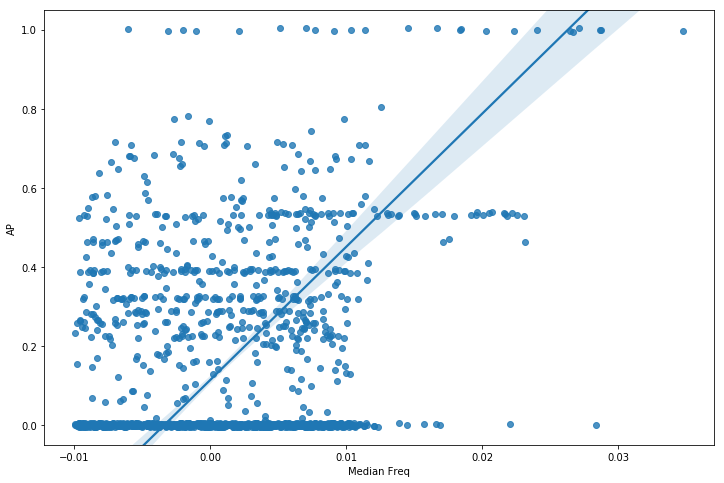

In [33]:
plt.figure(figsize=(12,8))
ax = sns.regplot(x="Median Freq", y="AP", data=score_freq, x_jitter=0.01, y_jitter=0.005);
ax.set(ylim=(-0.05, 1.05))


In [25]:
# analyze top-ranked word for term words scoring 0 MAP
crim_wrong_terms  = score_freq.loc[score_freq.AP==0, 'word'].tolist()

top_crim_wrong = []

for w in crim_wrong_terms:
    top_crim_wrong.append(predictions['Both'][w][0])
    
top_crim_wrong =  sorted([(v,k) for k, v in Counter(top_crim_wrong).items()], reverse=True)[:15]

# multiply words according to frequency
crim_wrong_flat = [li for lol in list(map(lambda w: [w[1]] * w[0], top_crim_wrong)) for li in lol  ]

combined_wrong_list = list(zip(['CRIM'] * len(crim_wrong_flat), crim_wrong_flat))
incorrect_df =  pd.DataFrame(combined_wrong_list, columns=['Model', 'Highest Ranked Incorrect Word'])

[Text(0,0,'person'),
 Text(0,0,'software'),
 Text(0,0,'city'),
 Text(0,0,'plant'),
 Text(0,0,'computer_program'),
 Text(0,0,'work_of_art'),
 Text(0,0,'natural_phenomenon'),
 Text(0,0,'computer_software'),
 Text(0,0,'chemical_reaction'),
 Text(0,0,'disease'),
 Text(0,0,'transportation'),
 Text(0,0,'expressway'),
 Text(0,0,'body_of_water'),
 Text(0,0,'film'),
 Text(0,0,'technical_specification')]

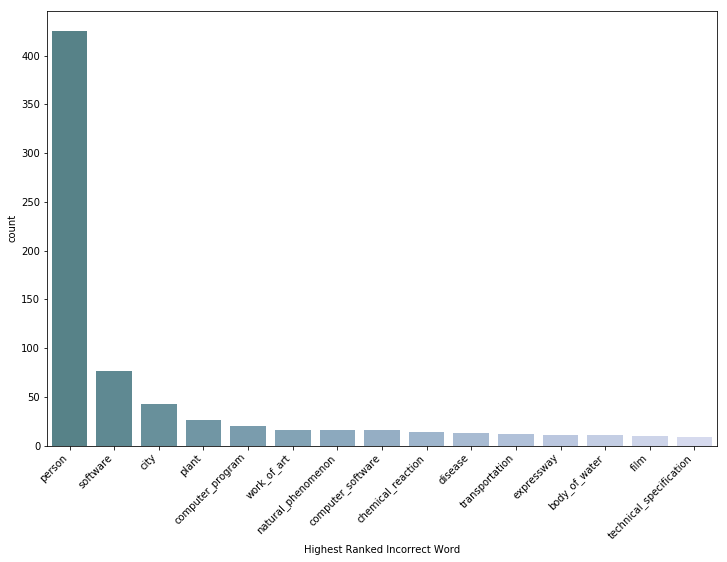

In [26]:
plt.figure(figsize=(12,8))
g = sns.countplot(x="Highest Ranked Incorrect Word", 
                  palette=sns.cubehelix_palette(15, start=2, rot=0.35, dark=0.47, light=0.85, reverse=True), 
                  data=incorrect_df)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, ha="right")


In [ ]:
for w in sorted([(v, k)for k, v in hyper_freq.items()], reverse=True)[:10]:
    print (w[1], w[0])
    


In [ ]:
for w in sorted([(v, k)for k, v in hyper_freq.items()], reverse=True)[:10]:
    print (w[1], w[0])

In [ ]:
# least frequent hypernyms
for w in [(v, k) for k, v in hyper_freq.items() if v == min(hyper_freq.values())][:10]:
    print (w[1], w[0])

In [38]:
# let's see good scores low frequency
good_words = score_freq.loc[(score_freq.AP >= 1.) & (score_freq['Median Freq'] < 1.) , 'word'].tolist()
score_freq.loc[(score_freq.AP >= 0.6) & (score_freq['Median Freq'] < 1.) , ]

,AP,Median Freq,word
20,0.668,0.002380,adobe_flash_lite
21,1.000,0.014645,adult
49,1.000,0.026320,andrew_mccormick
53,0.800,0.002675,anna_lindh
95,1.000,0.026320,authoress
99,0.655,0.002380,autoresponder
130,0.685,0.000510,bill_clinton
156,1.000,0.000420,bread
187,1.000,0.001525,camellia
189,0.690,0.000590,camlet


In [39]:
for w in good_words:
    print ("%s: %s" % (w, ", ".join(predictions['Both'][w])))
    print ("%s: %s" % (w, ", ".join(hyper_dict[w])))
    print ("-"*30)



adult: animal, person, communication_medium, computer_software, technology, software_program, network, web_site, technical_specification, mammal, services, software, software_application, non-human, providing
adult: person, animal
------------------------------
andrew_mccormick: person, leader, athlete, sport, company, software, corporation, chief, city, computer_software, technical_specification, sportsperson, enterprise, technology, competitor
andrew_mccormick: person
------------------------------
authoress: person, writer, leader, work_of_art, politician, motion_picture, fictional_character, poet, chief, teacher, film, literary_work, political_leader, musical_work, story
authoress: person
------------------------------
bread: food_product, foodstuff, meal, bread, product, yogurt, beverage, convenience_food, cereal, food_preparation, grocery, food_industry, frozen_foods, consumption, nutritious
bread: foodstuff, food_product
------------------------------
camellia: plant, woody_plan

In [ ]:
score_freq.loc[score_freq.AP >= 0.5,]

# Scratch Pad

In [ ]:
reload(semeval_data)
reload(multiprojection_model)
reload(multiprojection_max)
reload(multiprojection_dual)
reload(multiprojection_transfer)
reload(multiprojection_transfer_max)

reload(crim_evaluator)
reload(crim_dual_evaluator)
reload(crim_evaluator_max)


In [ ]:
len(set(read_vocab(vocab_file_name)).difference(set(vocabulary)))

In [ ]:
# remove vocab term having no vector in embeddings
def get_terms_having_vectors(w2v, dataset):
    return [(q,h) for q, h in dataset if q in w2v and h in w2v]

# remove any words which don't have corresponding embeddings 
for w in word_types:
    validation[w] = get_terms_having_vectors(model, validation[w])
    test[w] = get_terms_having_vectors(model, test[w])
    training[w] = get_terms_having_vectors(model, training[w])

vocabulary = list(filter(lambda w: w in model, vocabulary))   

In [ ]:
weights = np.load('weights/ft_semeval_5_Both.npz')
weights = weights['weights'].tolist()

In [ ]:
trans_model.model.get_layer('Phi0').set_weights([weights[0]])

In [ ]:
len(weights)